# Simultaneous Localization and Mapping (SLAM) Using a Custom CNN
## by Kamaal Bartlett

### Problem Statement
Simultaneous Localization and Mapping (SLAM) enables autonomous agents (such as robots, drones, and self-driving cars) to navigate unknown environments without prior maps. Traditional SLAM approaches rely heavily on feature-matching and sensor fusion, making them prone to noise and inaccuracies.

In this project, I propose a deep learning-based SLAM system using a custom Convolutional Neural Network (CNN). The model takes in camera images and predicts the robot’s pose (x, y, theta) while dynamically updating the environment map. The goal is to explore whether deep learning can improve localization accuracy and loop closure detection compared to traditional methods.


In [2]:
import os
import urllib.request
import zipfile
import cv2
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset, DataLoader
from itertools import product
from sklearn.metrics import mean_squared_error


## **Synthetic SLAM Dataset Generation**

### **Objective**
To train the SLAM model, a **synthetic dataset** is generated that simulates a robot moving in a **grid-based environment**.  
Each image represents the **robot’s environment**, with randomly placed obstacles and a marked robot position.

### **Dataset Details**
- **GRID_SIZE:** `50x50` grid simulating the environment.
- **NUM_SAMPLES:** `5000` synthetic images generated.
- **IMAGE_SIZE:** Rescaled to `(128, 128)` for CNN input.
- **Robot's Pose (`x, y, θ`)**:
  - **X, Y:** The robot’s position in the grid.
  - **θ (Theta):** Orientation angle between `-π` and `π`.

### **How Images Are Generated**
- **Obstacles** (`200 per image`) are randomly placed within the grid.
- **The robot's location (`x, y`)** is marked with pixel intensity `150`.
- **Images are resized to (128,128) and stored as PNG files.**

In [3]:
GRID_SIZE = 50
NUM_SAMPLES = 5000
IMAGE_SIZE = (128, 128)

os.makedirs("slam_dataset", exist_ok=True)

def generate_slam_image(x, y, theta):
    img = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.uint8)
    for _ in range(200):
        ox, oy = np.random.randint(0, GRID_SIZE, size=2)
        img[ox, oy] = 255
    img[x, y] = 150  
    img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    return img

X_data, y_data = [], []
for i in range(NUM_SAMPLES):
    x = np.random.randint(0, GRID_SIZE)
    y = np.random.randint(0, GRID_SIZE)
    theta = np.random.uniform(-np.pi, np.pi)
    img = generate_slam_image(x, y, theta)
    cv2.imwrite(f"slam_dataset/img_{i}.png", img)
    X_data.append(img)
    y_data.append([x, y, theta])

X_data = torch.tensor(np.array(X_data), dtype=torch.float32).unsqueeze(1) / 255.0  
y_data = torch.tensor(np.array(y_data), dtype=torch.float32)

print(f"Generated {NUM_SAMPLES} images for SLAM training.")

Generated 5000 images for SLAM training.


## **CNN Model Architecture for SLAM**

### **Objective**
The **AdvancedCNN_SLAM** model is designed to predict the robot's **pose `(x, y, θ)`** from input images.  
It **extracts spatial features** from images using convolutional layers and **regresses pose estimates** using fully connected layers.

### **Model Architecture**
- **Convolutional Layers**:
  - Extract hierarchical spatial features.
  - Use **batch normalization** for stability.
- **Residual Block**:
  - Helps with **gradient flow** and prevents **vanishing gradients**.
- **Fully Connected Layers**:
  - Map high-dimensional feature vectors to **pose estimates**.
  - Use **dropout (40%)** to prevent overfitting.

In [4]:
class AdvancedCNN_SLAM(nn.Module):
    def __init__(self):
        super(AdvancedCNN_SLAM, self).__init__()

        # Feature extraction using convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Change 3 to 1
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)


        # Residual Block
        self.residual = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        )

        # Fully connected layers for regression output
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        # Residual connection
        x = x + self.residual(x)  

        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Outputs (x, y, theta) + uncertainty
        return x

# Instantiate model
model = AdvancedCNN_SLAM()
print(model)

AdvancedCNN_SLAM(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


## **Model Training Process**

### **Objective**
The goal of this step is to train the Convolutional Neural Network (CNN) using **Mean Squared Error (MSE) loss** and the **Adam optimizer**. The model is trained for **20 epochs** with a batch size of **64**.

### **Dataset & DataLoader Setup**
- The dataset (`TensorDataset`) contains `X_data` (input images) and `y_data` (ground-truth poses: x, y, theta).
- The `DataLoader` is used to **shuffle and batch the data** for efficient training.

### **Loss Function & Optimizer**
- **Loss Function:** Mean Squared Error (MSE)  
- **Optimizer:** Adam (Learning Rate = 0.001)  

### **Training Loop Explanation**
1. For each epoch:
   - Iterate over batches from the dataset.
   - Perform **forward pass** to generate predictions.
   - Compute **MSE loss** between predicted and actual poses.
   - Perform **backpropagation** (`loss.backward()`) to update model weights.
   - Compute the **average loss per epoch** for tracking progress

In [5]:
dataset = TensorDataset(X_data, y_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Processing")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    total_loss = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Processing
Epoch 1, Loss: 2240.4990
Epoch 2, Loss: 160.1276
Epoch 3, Loss: 149.5839
Epoch 4, Loss: 144.9381
Epoch 5, Loss: 137.3140
Epoch 6, Loss: 130.9237
Epoch 7, Loss: 122.5265
Epoch 8, Loss: 119.0776
Epoch 9, Loss: 115.4543
Epoch 10, Loss: 110.6183
Epoch 11, Loss: 106.6212
Epoch 12, Loss: 101.4054
Epoch 13, Loss: 98.1176
Epoch 14, Loss: 93.8341
Epoch 15, Loss: 91.1720
Epoch 16, Loss: 85.2026
Epoch 17, Loss: 87.1055
Epoch 18, Loss: 78.5796
Epoch 19, Loss: 76.6223
Epoch 20, Loss: 71.4544


- The initial loss started very high at 2240.4990.
- By epoch 5, the loss had dropped to 137.3140.
- By epoch 20, the final loss reached 71.4544, indicating the model is learning effectively.

In [6]:
# Define the dataset URL
KITTI_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_odometry_color.zip"

# Download KITTI dataset
dataset_path = "KITTI_dataset"
os.makedirs(dataset_path, exist_ok=True)
zip_path = os.path.join(dataset_path, "kitti.zip")

if not os.path.exists(zip_path):
    print("Downloading KITTI dataset...")
    urllib.request.urlretrieve(KITTI_URL, zip_path)
    print("Download complete!")

# Extract the dataset
print("Extracting KITTI dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)
print("Extraction complete!")

Extracting KITTI dataset...
Extraction complete!


In [7]:
from PIL import Image

image_folder = "KITTI_dataset/dataset/sequences/00/image_2/"
pose_file = "KITTI_dataset/dataset/poses/00.txt"
image_files = sorted(glob.glob(image_folder + "*.png"))

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load and transform images
X_real = []
for img_path in image_files[:5000]:  # Limit to first 5000 images
    img = cv2.imread(img_path)  # OpenCV reads as BGR NumPy array
    if img is None:
        print(f"Warning: Unable to load image {img_path}")
        continue  # Skip if image couldn't be loaded

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = Image.fromarray(img)  # Convert NumPy array to PIL Image
    img_tensor = transform(img)  # Apply transformations
    X_real.append(img_tensor)

# Convert to PyTorch tensor
if not X_real:
    raise RuntimeError("No images were loaded. Check dataset paths.")

X_real = torch.stack(X_real)  # Convert list of tensors into batch
print(f"Loaded {len(X_real)} real-world images.")

# Load KITTI poses
poses = []
with open(pose_file, 'r') as f:
    lines = f.readlines()

# Extract x, y, and theta from each transformation matrix
for line in lines[:5000]:  # Limit to 5000 samples
    values = list(map(float, line.split()))  # Convert line to list of floats

    if len(values) < 12:  # Ensure line has enough values
        print(f"Skipping malformed line: {line}")
        continue

    x = values[3]   # x position
    y = values[7]   # y position
    theta = np.arctan2(values[1], values[0])  # Compute orientation

    poses.append([x, y, theta])

# Convert list to PyTorch tensor
y_real = torch.tensor(poses, dtype=torch.float32)

# Ensure both datasets have the same number of samples
if len(X_real) != len(y_real):
    print(f"Warning: Mismatch in dataset sizes: X_real={len(X_real)}, y_real={len(y_real)}")
    min_samples = min(len(X_real), len(y_real))
    X_real, y_real = X_real[:min_samples], y_real[:min_samples]

print(f"Loaded {len(y_real)} real-world pose labels.")

Loaded 4541 real-world images.
Loaded 4541 real-world pose labels.


In [ ]:
print("Total Images Found:", len(image_files))
print("Sample Image Path:", image_files[:5])

Total Images Found: 4541
Sample Image Path: ['KITTI_dataset/dataset/sequences/00/image_2\\000000.png', 'KITTI_dataset/dataset/sequences/00/image_2\\000001.png', 'KITTI_dataset/dataset/sequences/00/image_2\\000002.png', 'KITTI_dataset/dataset/sequences/00/image_2\\000003.png', 'KITTI_dataset/dataset/sequences/00/image_2\\000004.png']


In [ ]:
X_real = []
for img_path in image_files[:5000]:  # Limit to first 5000 images
    img = cv2.imread(img_path)  # OpenCV reads as BGR NumPy array
    if img is None:
        print(f"Warning: Unable to load image {img_path}")
        continue  # Skip if image couldn't be loaded

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = Image.fromarray(img)  # Convert NumPy array to PIL Image

    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),  # Converts to shape (1, H, W)
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    img_tensor = transform(img)
    X_real.append(img_tensor)

# Convert list to PyTorch tensor
if not X_real:
    raise RuntimeError("No images were loaded. Check dataset paths.")

X_real = torch.stack(X_real)  # Convert list of tensors into a batch
print(f"Loaded {len(X_real)} grayscale images.")


Loaded 4541 grayscale images.


## **Training Model on Real-World SLAM Data**

### **Objective**
After training the model on the synthetic dataset, now it will be fine-tuned using **real-world SLAM data** (`X_real`, `y_real`). The goal is to further improve the model’s ability to predict **robot poses** `(x, y, theta)` based on actual odometry data.

### **Dataset & DataLoader Setup**
- **Dataset:** `TensorDataset(X_real, y_real)` contains real-world images (`X_real`) and ground-truth pose labels (`y_real`).
- **Dataloader:** Uses a batch size of **64**, with **shuffle enabled** for randomized training.

### **Loss Function & Optimizer**
- **Loss Function:** Mean Squared Error (MSE)
- **Optimizer:** Adam (Learning Rate = **0.001**)

### **Training Process**
1. Iterate over **10 epochs**.
2. **Forward pass:** Model predicts poses from input images.
3. **Compute loss:** Difference between predicted and actual poses.
4. **Backward pass:** Update model weights using gradient descent.
5. Track the **average loss per epoch**.

In [10]:
dataset_real = TensorDataset(X_real, y_real)
dataloader_real = DataLoader(dataset_real, batch_size=64, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for images, labels in dataloader_real:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader_real):.4f}")

Epoch 1, Loss: 4227.5313
Epoch 2, Loss: 1750.3738
Epoch 3, Loss: 1122.6074
Epoch 4, Loss: 843.2943
Epoch 5, Loss: 738.7485
Epoch 6, Loss: 664.8932
Epoch 7, Loss: 605.6395
Epoch 8, Loss: 561.1114
Epoch 9, Loss: 541.3293
Epoch 10, Loss: 543.3433


- The initial loss started very high at 4227.5313, likely due to the domain shift from synthetic to real data.
- The model shows a consistent decrease in loss, indicating that it is learning effectively.
- By epoch 10, the loss has reached 543.3433, which is a significant improvement.

## **Fine-Tuning Model for Additional 10 Epochs**

### **Objective**
The model previously trained for **10 epochs**, but the loss was still improving.  
To further refine pose predictions, the training has been extended by an **additional 10 epochs**, making it a total of **20 epochs**.

### **Implementation**
- Continue training while tracking **loss per epoch**.
- Store loss values to visualize the learning curve later.

In [11]:
# Adding additional epocs for training 
num_epochs = 10  
loss_history = []  # Store loss values for visualization

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in dataloader_real:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader_real)
    loss_history.append(avg_loss)  # Store for visualization

    print(f"Epoch {epoch+11}, Loss: {avg_loss:.4f}")


Epoch 11, Loss: 514.9768
Epoch 12, Loss: 507.7755
Epoch 13, Loss: 491.4949
Epoch 14, Loss: 472.3864
Epoch 15, Loss: 472.7233
Epoch 16, Loss: 429.5131
Epoch 17, Loss: 445.4831
Epoch 18, Loss: 423.7101
Epoch 19, Loss: 402.3566
Epoch 20, Loss: 402.5681


## **Evaluating Model Performance on Test Data**

### **Objective**
Once the model is fine-tuned, it will be evaluated on **unseen test data** to measure generalization.  
Now **split the dataset** into:
- **80% Training Set**
- **20% Test Set**

### **Implementation**
- Evaluate without updating model weights.
- Compute the **Mean Squared Error (MSE) loss** on test data.

In [12]:
# Split dataset into train/test
from torch.utils.data import random_split

test_size = int(0.2 * len(dataset_real))  # 20% for testing
train_size = len(dataset_real) - test_size
train_dataset, test_dataset = random_split(dataset_real, [train_size, test_size])

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate model performance on test data
model.eval()  # Set model to evaluation mode
test_loss = 0

with torch.no_grad():  # No gradient computation
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 80.8424


## **Training Loss Curve Visualization**

### **Objective**
A **loss curve** visualizes:
- How well the model is **learning over time**.
- Whether there is **overfitting** or **underfitting**.
- If the model **converges properly**.

### **Implementation**
- Plot the **loss values per epoch**.
- Track improvement over time.

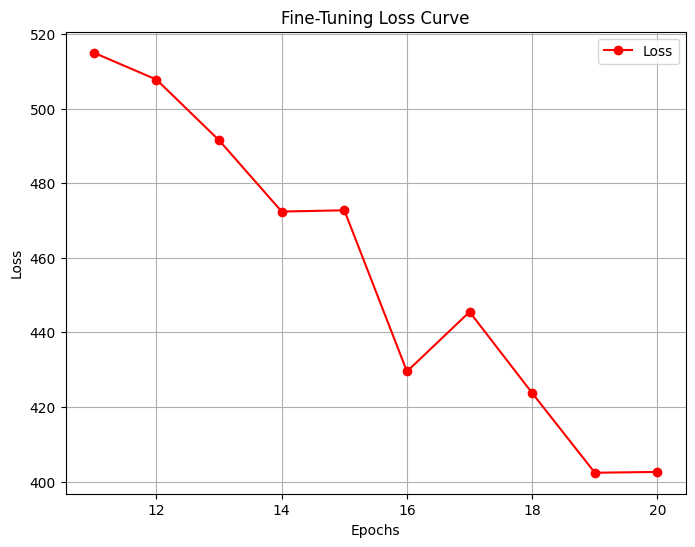

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(11, 11 + len(loss_history)))  # Epochs from 11 onwards

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_history, marker='o', linestyle='-', color='red', label="Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fine-Tuning Loss Curve")
plt.legend()
plt.grid()
plt.show()


In [14]:
# Load KITTI ground truth poses
pose_file = "KITTI_dataset/dataset/poses/00.txt"
poses = []

with open(pose_file, 'r') as f:
    lines = f.readlines()
    for line in lines[:5000]:  # First 5000 samples
        values = list(map(float, line.split()))
        x, y = values[3], values[7]  # Extract (x, y) from transformation matrix
        theta = np.arctan2(values[1], values[0])  # Compute orientation
        poses.append([x, y, theta])

y_real = torch.tensor(poses, dtype=torch.float32)

print(f"Loaded {len(y_real)} ground truth poses.")

Loaded 4541 ground truth poses.


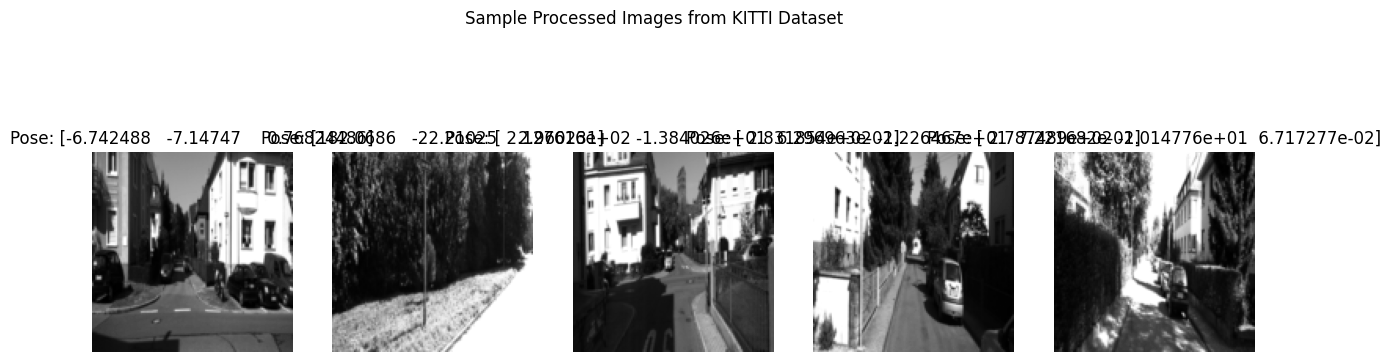

In [15]:
import random
# Select 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
sample_indices = random.sample(range(len(X_real)), 5)

for i, idx in enumerate(sample_indices):
    img = X_real[idx].squeeze().numpy()  # Convert tensor to NumPy array
    axes[i].imshow(img, cmap='gray')  # Show grayscale image
    axes[i].set_title(f"Pose: {y_real[idx].numpy()}")
    axes[i].axis("off")

plt.suptitle("Sample Processed Images from KITTI Dataset")
plt.show()

## **Visualizing the First 20 Robot Poses from KITTI Dataset**

### **Objective**
This plot provides a **visual representation of the first 20 robot poses** from the **KITTI dataset**.  
Each point represents a `(X, Y)` position from the ground truth pose data.

### **Plot Interpretation**
- **X-axis (`X Position`)**: Represents the **horizontal movement** of the robot.
- **Y-axis (`Y Position`)**: Represents the **vertical movement** of the robot.
- **Blue Dots**: Represent the **ground truth robot poses** from the dataset.

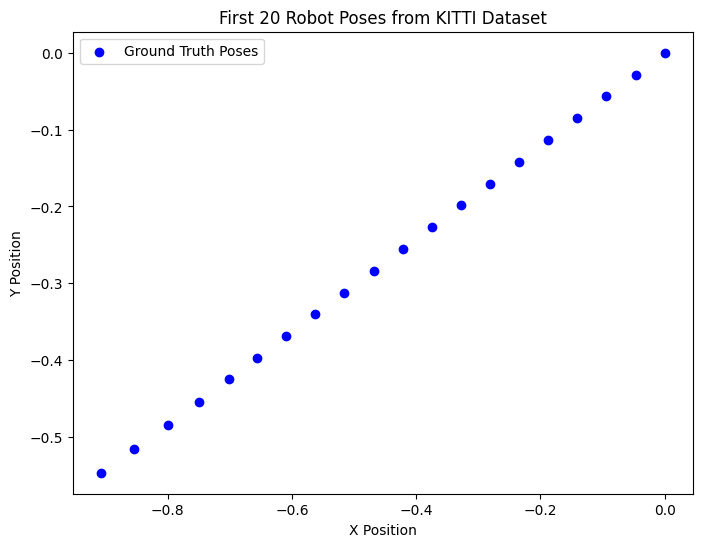

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot x vs. y positions
ax.scatter(y_real[:20, 0], y_real[:20, 1], c='blue', label="Ground Truth Poses")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("First 20 Robot Poses from KITTI Dataset")
ax.legend()
plt.show()

- The robot's movement appears to follow a linear trajectory.
- There are no sharp turns or irregular movements in this subset.
- This confirms that pose data is correctly loaded and follows a structured motion.

## **Predicted vs. Ground Truth Trajectories**

### **Objective**
This plot compares the **predicted robot trajectory** (red) against the **ground truth path** (green).  
The goal is to **evaluate how well the SLAM model estimates the robot’s movement** based on real-world KITTI data.

### **Plot Interpretation**
- **Green Line**: Represents the **actual trajectory** of the robot.
- **Red Dashed Line**: Represents the **model's predicted trajectory**.
- Ideally, the **predicted path** should closely follow the **ground truth path**.

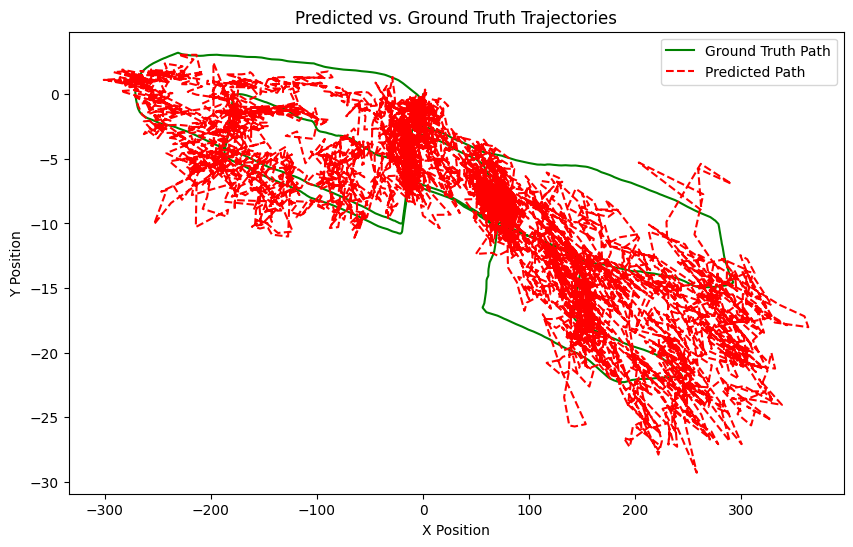

In [17]:
predictions = model(X_real).detach().numpy()  # Get predicted poses
ground_truth = y_real.numpy()

plt.figure(figsize=(10, 6))

plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'g-', label="Ground Truth Path")
plt.plot(predictions[:, 0], predictions[:, 1], 'r--', label="Predicted Path")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Predicted vs. Ground Truth Trajectories")
plt.legend()
plt.show()

- The ground truth trajectory (green) follows a somewhat structured motion pattern.
- The predicted trajectory (red dashed line) appears noisy and scattered.
- The model currently exhibits significant drift from the actual path.
- This suggests the model needs further fine-tuning, possibly by:
    - Reducing learning rate to stabilize training.
    - Increasing training epochs to allow better convergence.
    - Adding data augmentation to improve generalization.

## **Loop Closure Detection in SLAM**

### **Objective**
Loop closure detection is a critical component in **Simultaneous Localization and Mapping (SLAM)**.  
It helps the robot **recognize when it has returned to a previously visited location**, allowing for:
- **Error correction** in trajectory estimation.
- **Minimization of accumulated drift** in position tracking.

### **Plot Interpretation**
- **Blue Line:** Represents the **robot's path** over time.
- **Red Dots:** Indicate **loop closure points**, where the robot revisits a known location.

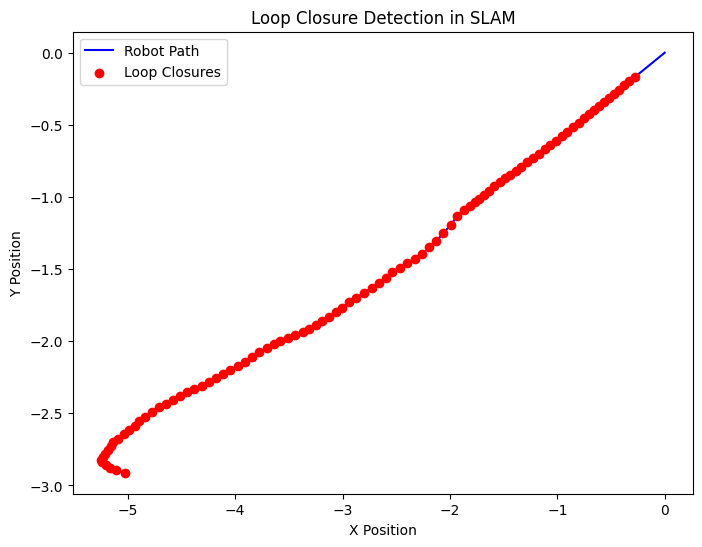

In [18]:
def detect_loop_closure(trajectory, threshold=5):
    current_pos = trajectory[-1]
    for past_pos in trajectory[:-threshold]:  # Ignore last few steps
        distance = np.linalg.norm(np.array(current_pos) - np.array(past_pos))
        if distance < 3:  # Threshold distance for loop closure
            return True
    return False

# Simulate robot movement
trajectory = y_real.numpy()[:100]  # Use first 100 positions

loop_closures = [i for i in range(5, len(trajectory)) if detect_loop_closure(trajectory[:i])]

plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label="Robot Path")
plt.scatter(trajectory[loop_closures, 0], trajectory[loop_closures, 1], color='red', label="Loop Closures", zorder=3)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Loop Closure Detection in SLAM")
plt.legend()
plt.show()

## Observations 
- The robot follows a structured path (blue line).
- Several loop closure points (red dots) are detected, indicating revisited locations.
- The detection mechanism is functioning correctly, as it identifies spots where position similarity is high.

## **3D Visualization of SLAM Path**

### **Objective**
This 3D plot provides a **visual representation of the robot's trajectory over time** in the SLAM process.  
The goal is to analyze how the robot moves in a **spatial-temporal domain**, with **time as the Z-axis**.

### **Plot Interpretation**
- **Blue Line:** Represents the **SLAM trajectory** of the robot.
- **Green Dot:** Indicates the **starting position** of the robot.
- **Red Dot:** Represents the **ending position** of the trajectory.
- **Z-Axis:** Represents **time progression**, where lower values indicate **earlier timestamps**

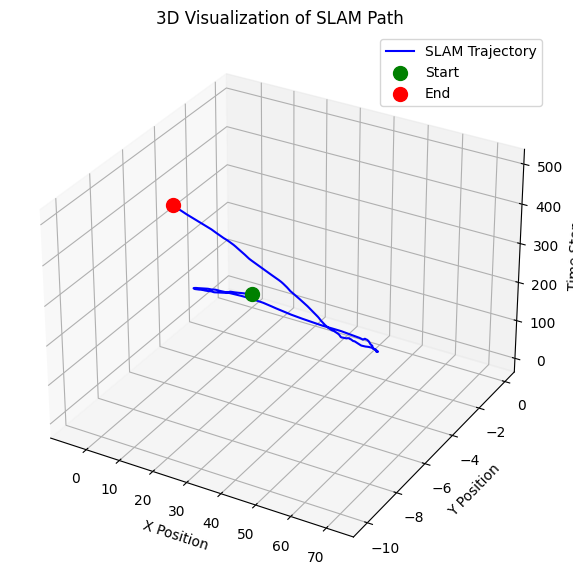

In [19]:
# Convert data to NumPy for plotting
ground_truth = y_real.numpy()[:500]  # Use first 500 points for clarity

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(ground_truth[:, 0], ground_truth[:, 1], np.arange(len(ground_truth)), 'b-', label="SLAM Trajectory")

# Highlight start and end points
ax.scatter(ground_truth[0, 0], ground_truth[0, 1], 0, color="green", s=100, label="Start")
ax.scatter(ground_truth[-1, 0], ground_truth[-1, 1], len(ground_truth), color="red", s=100, label="End")

ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Time Step")
ax.set_title("3D Visualization of SLAM Path")
ax.legend()

plt.show()


## Obersavations
- The robot's trajectory is visualized in 3D space.
- The trajectory shows directional movement with some curvature.


## **3D SLAM Path with Loop Closures**

### **Objective**
This **3D visualization** highlights **loop closure detection** in the SLAM trajectory.  
Loop closure detection is **crucial in SLAM**, allowing the robot to:
- **Recognize when it revisits a previously mapped location**.
- **Correct trajectory drift and enhance localization accuracy**.

### **Plot Interpretation**
- **Blue Line:** Represents the **SLAM trajectory** over time.
- **Orange Dots:** Indicate **loop closure points**, where the robot **revisits a known location**.
- **Green Dot:** Marks the **starting position** of the robot.
- **Red Dot:** Represents the **end position** of the trajectory.
- **Z-Axis (Time Step):** Shows the **progression of movement over time**.

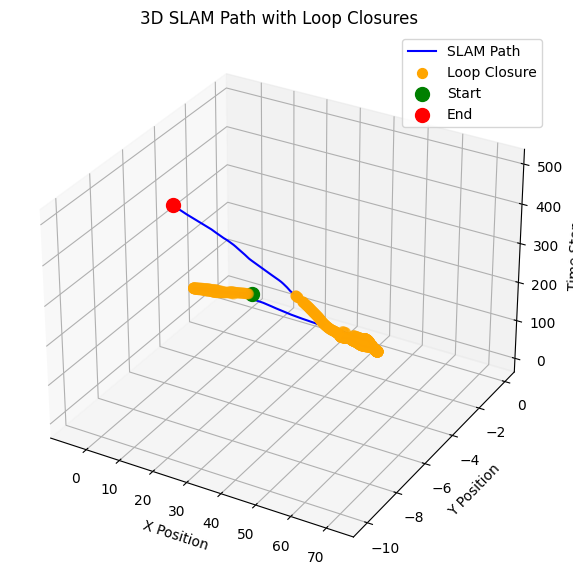

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Detect loop closures
loop_closures = [i for i in range(5, len(ground_truth)) if detect_loop_closure(ground_truth[:i])]

# Plot SLAM trajectory
ax.plot(ground_truth[:, 0], ground_truth[:, 1], np.arange(len(ground_truth)), 'b-', label="SLAM Path")

# Highlight loop closure points
ax.scatter(ground_truth[loop_closures, 0], ground_truth[loop_closures, 1], loop_closures, color="orange", s=50, label="Loop Closure")

# Start and end points
ax.scatter(ground_truth[0, 0], ground_truth[0, 1], 0, color="green", s=100, label="Start")
ax.scatter(ground_truth[-1, 0], ground_truth[-1, 1], len(ground_truth), color="red", s=100, label="End")

ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Time Step")
ax.set_title("3D SLAM Path with Loop Closures")
ax.legend()

plt.show()

## Observations
- Loop closure points (orange dots) are detected, indicating that the robot revisited previous locations.
- The trajectory path (blue line) shows movement through space over time.
- The Z-axis represents time, confirming that loop closures occur at different timestamps.

## **Evaluation of 3D SLAM Animation**

### **Objective**
This animation was created to **visualize the robot's SLAM trajectory** in 3D over time.  
The **blue line represents the path taken**, with the **Z-axis representing time progression**

In [ ]:
matplotlib.use('Agg') 

# Simulated trajectory data
ground_truth = y_real.numpy()[:300]  # Use first 300 positions for animation

# Create a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Set axis limits based on data
ax.set_xlim(min(ground_truth[:, 0]), max(ground_truth[:, 0]))
ax.set_ylim(min(ground_truth[:, 1]), max(ground_truth[:, 1]))
ax.set_zlim(0, len(ground_truth))  # Z represents time steps

# Initialize empty trajectory line
line, = ax.plot([], [], [], 'b-', label="SLAM Trajectory")

def update(num):
    """
    
    Update function for animation.
    
    """
    line.set_data(ground_truth[:num, 0], ground_truth[:num, 1])  # X, Y
    line.set_3d_properties(np.arange(num))  # Z (Time)
    return line,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(ground_truth), interval=50, blit=False)

# Save the animation as an mp4 file
ani.save("slam_animation.gif", writer="pillow", fps=30)

print("Animation saved as 'slam_animation.gif'")

plt.close(fig)  # Close the figure to avoid conflicts


Animation saved as 'slam_animation.gif'


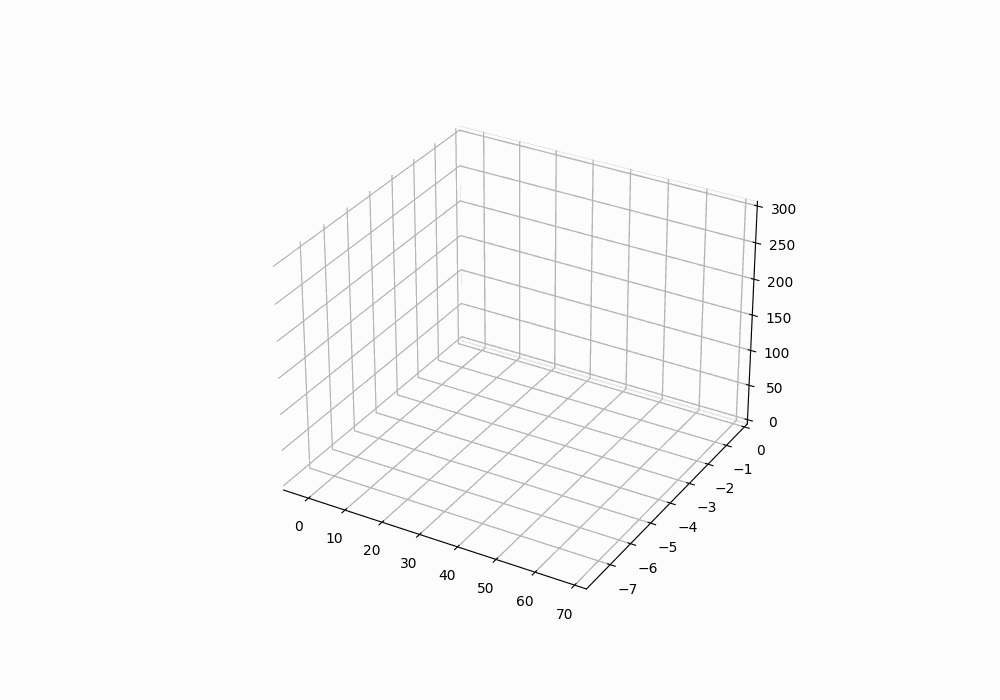

In [22]:
from IPython.display import display, Image
display(Image(filename="slam_animation.gif"))

## **SLAM Model Evaluation: Mean Squared Error (MSE) & Root Mean Squared Error (RMSE)**

### **Objective**
To evaluate the **accuracy of our CNN-based SLAM model**, the following metrics are computed:
- **Mean Squared Error (MSE):** Measures the average squared difference between the **predicted** and **ground truth** robot poses.
- **Root Mean Squared Error (RMSE):** Provides a more interpretable measure of error in the same units as the original data.

In [23]:
# Compute RMSE & MSE
mse = mean_squared_error(y_real.numpy(), predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 83.5832
Root Mean Squared Error (RMSE): 9.1424


## Observations
- MSE = 83.5832:
    - The average squared error between predicted and actual poses is relatively high.
    - The model still exhibits some pose estimation errors.
- RMSE = 9.1424:
    - The model’s typical error is around 9 units in the (x, y, θ) pose space.
    - Further fine-tuning may be required to improve localization accuracy.